In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV, cross_val_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve,auc, precision_recall_curve, accuracy_score, f1_score, matthews_corrcoef
from xgboost import XGBClassifier
import os

import plotly.offline as py
py.init_notebook_mode(connected=True)
import lightgbm as lgbm

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from yellowbrick.classifier import DiscriminationThreshold

# Stats
import scipy.stats as ss
from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Time
from contextlib import contextmanager
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


import warnings
warnings.filterwarnings('ignore')

/home/ashwani/.local/lib/python3.10/site-packages/kaleido/__init__.py:14: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




In [2]:
# ---------- Settings ----------
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (10, 6)


In [3]:
df = pd.read_csv('diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# ---------- Quick look on dataset ----------


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.describe()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# ---------- Target distribution ----------


In [6]:
print("\nOutcome value counts:")
print(df['Outcome'].value_counts())
print("\nOutcome percentages:")
print(df['Outcome'].value_counts(normalize=True) * 100)


Outcome value counts:
0    500
1    268
Name: Outcome, dtype: int64

Outcome percentages:
0    65.104167
1    34.895833
Name: Outcome, dtype: float64


In [7]:
outcome_counts = df['Outcome'].value_counts().reset_index()
outcome_counts.columns = ['Outcome', 'Count']

# Plot pie chart
fig = px.pie(outcome_counts,
             values='Count',
             names='Outcome',
             title="Distribution of Diabetes Outcomes",
             hole=0.3) 

fig.show()


# ---------- Check missing / zero values ----------


In [8]:
# In this dataset zeros often indicate missing for certain columns:
zero_as_missing_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

def zeros_summary(df, cols):
    for c in cols:
        n_zero = (df[c] == 0).sum()
        print(f"{c}: zeros = {n_zero} ({n_zero / len(df) * 100:.2f}%)")

zeros_summary(df, zero_as_missing_cols)

Glucose: zeros = 5 (0.65%)
BloodPressure: zeros = 35 (4.56%)
SkinThickness: zeros = 227 (29.56%)
Insulin: zeros = 374 (48.70%)
BMI: zeros = 11 (1.43%)


In [9]:
# Replace clinically-impossible zeros with NaN for those features
df_na = df.copy()
df_na[zero_as_missing_cols] = df_na[zero_as_missing_cols].replace(0, np.nan)

print("\nMissing per column (after replacing zeros):")
display(df_na.isna().sum())


Missing per column (after replacing zeros):


Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

# ---------- Univariate distributions ----------


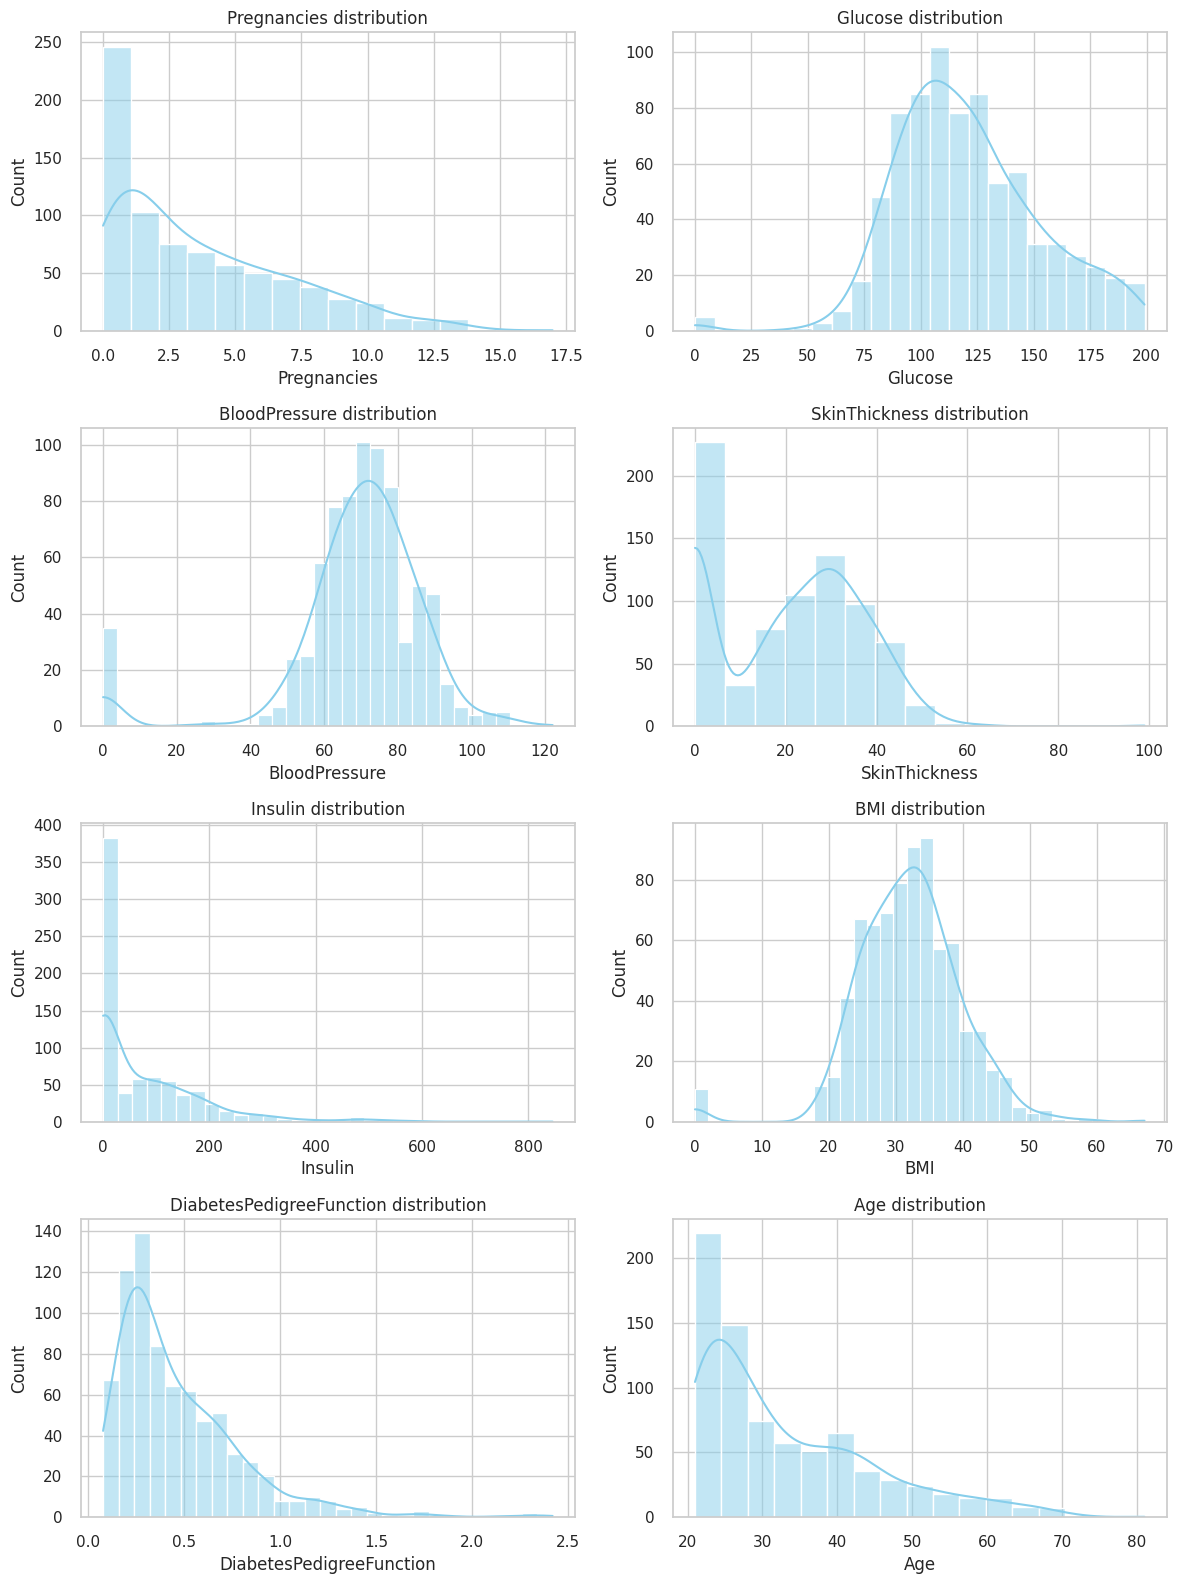

In [10]:
# # Numeric histogram + KDE
# num_cols = df.columns.drop('Outcome')
# for c in num_cols:
#     plt.figure(figsize=(8,4))
#     sns.histplot(data=df, x=c, kde=True)
#     plt.title(f"{c} distribution")
#     plt.show()

import math
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = df.columns.drop('Outcome')

# Calculate number of rows (2 plots per row)
n_cols = 2
n_rows = math.ceil(len(num_cols) / n_cols)

plt.figure(figsize=(12, n_rows * 4))

for i, c in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data=df, x=c, kde=True, color='skyblue')
    plt.title(f"{c} distribution", fontsize=12)
    plt.xlabel(c)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


# ---------- Boxplots ----------


In [11]:
# Boxplots by Outcome for numeric features
for c in num_cols:
    fig = px.box(
        df, x='Outcome', y=c, color='Outcome',
        points='outliers',
        title=f"{c} by Outcome (0 = no diabetes, 1 = diabetes)"
    )
    fig.show()

# ---------- Pairwise relationships ----------


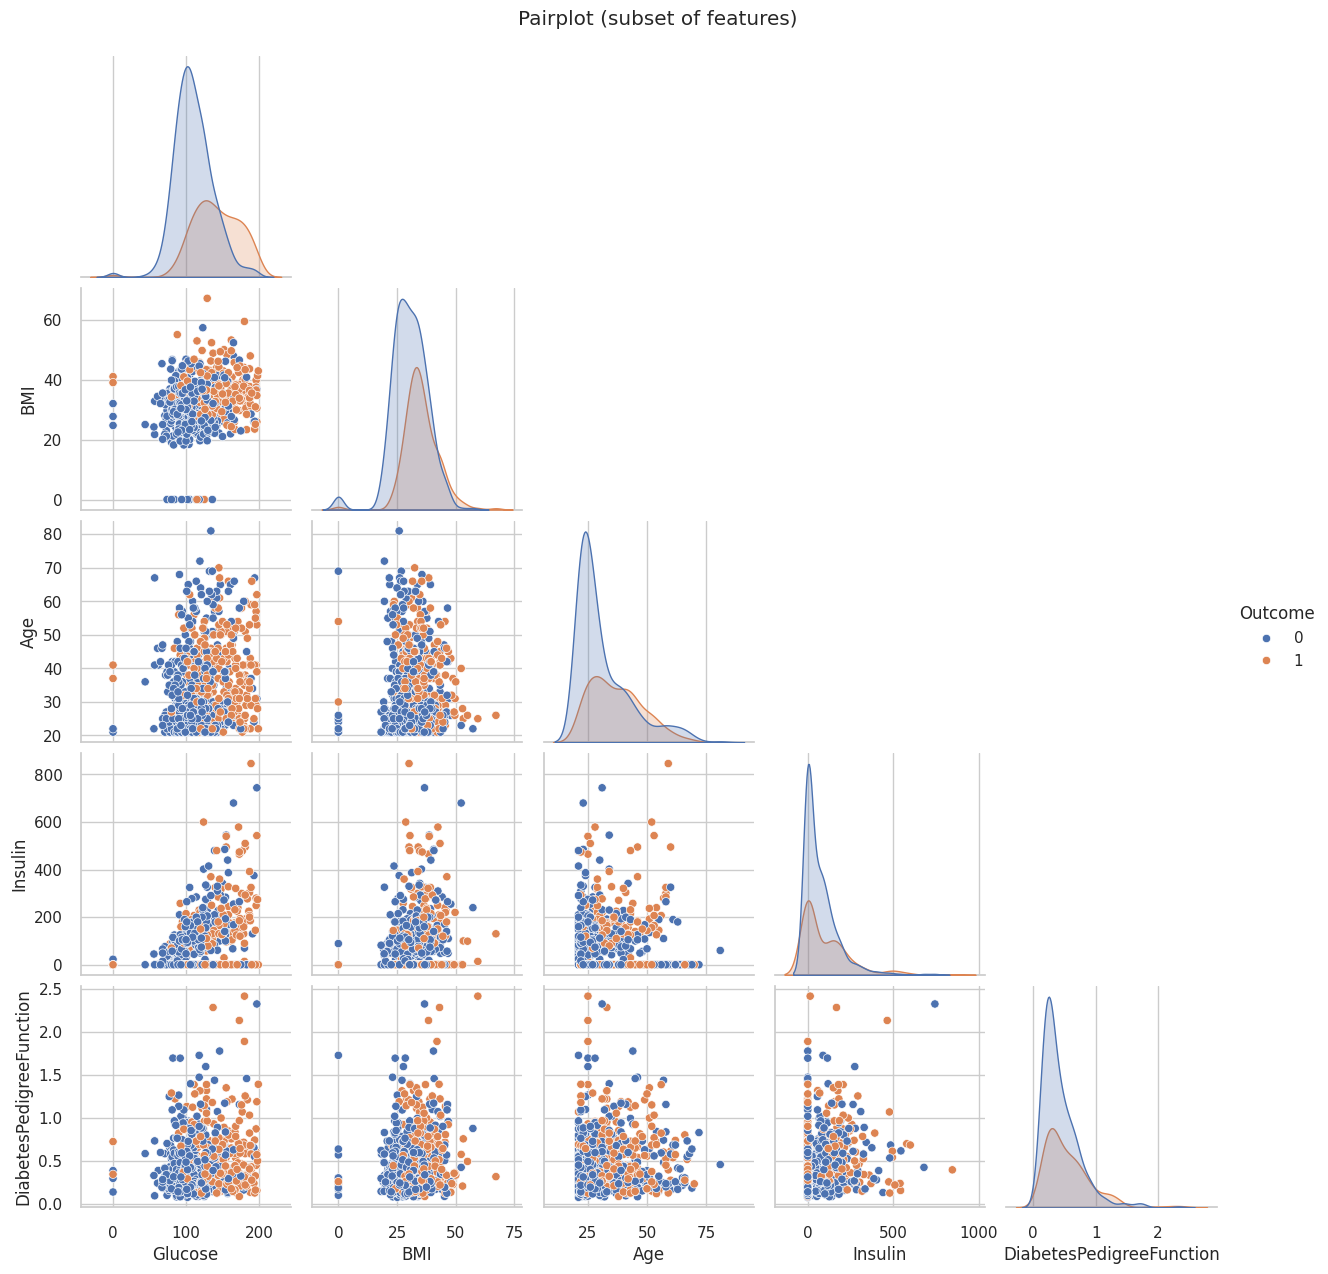

In [12]:
# Pairplot for a subset 
subset_cols = ['Glucose', 'BMI', 'Age', 'Insulin', 'DiabetesPedigreeFunction', 'Outcome']
sns.pairplot(df[subset_cols], hue='Outcome', diag_kind='kde', corner=True)
plt.suptitle("Pairplot (subset of features)", y=1.02)
plt.show()


# ---------- Correlation matrix ----------


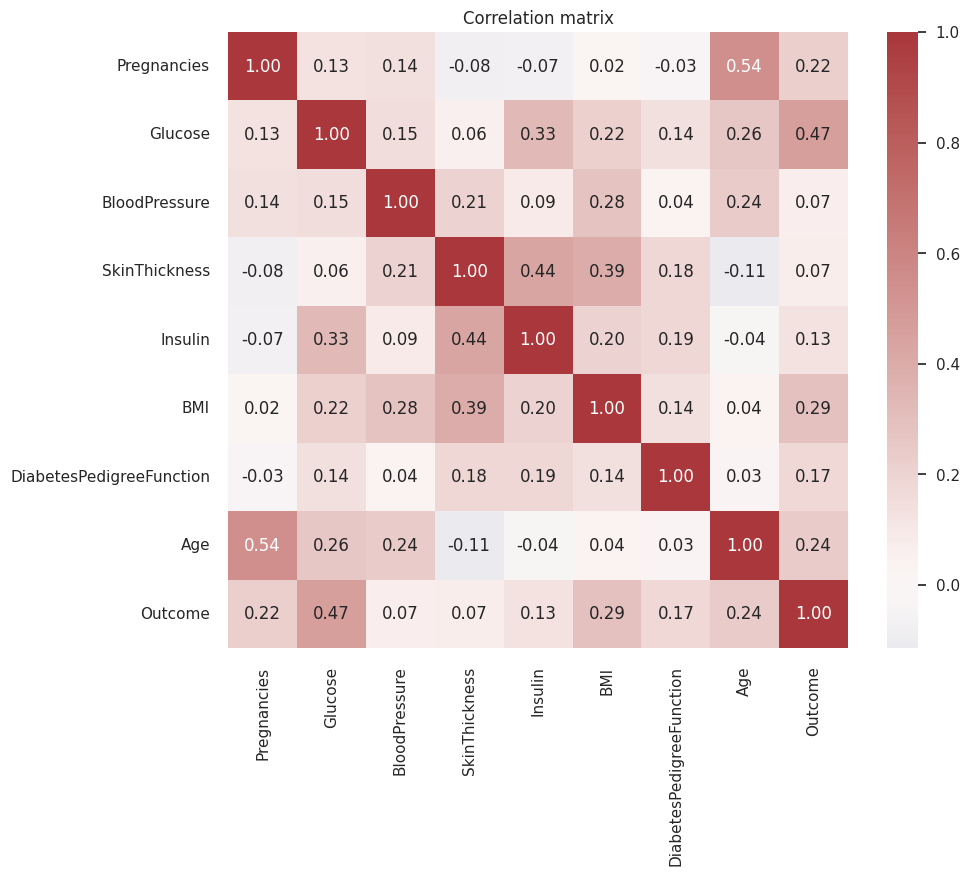

Absolute correlation with Outcome (descending):


Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64

In [13]:
corr = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title("Correlation matrix")
plt.show()

# ---------- Correlation with Outcome (sorted) ----------
corr_with_target = corr['Outcome'].drop('Outcome').abs().sort_values(ascending=False)
print("Absolute correlation with Outcome (descending):")
display(corr_with_target)

## Glucose seems to be highly correlated to diabetes(Outcome column) condition compared to other predictors 

In [14]:
# Using Plotly

# corr = df.corr()
# fig = px.imshow(corr,
#                 text_auto='.2f',   # for 2 decimal formatting
#                 color_continuous_scale='RdBu_r',
#                 # color_continuous_scale=[[0, 'red'], [0.5, 'white'], [1, 'darkred']]

#                 )
# fig.update_traces(textfont_size=14)  # increase text size
# fig.update_layout(
#     width=1000,
#     height=800,
#     title_font_size=22,
#     title_x=0.5
# )

# fig.show()


# ---------- Handling missing value   ----------


In [15]:
df.groupby('Outcome')['Insulin'].median()

Outcome
0    39.0
1     0.0
Name: Insulin, dtype: float64

In [16]:
# Median imputation for clinical features
df_imputed = df_na.copy()

for c in zero_as_missing_cols:
    df_imputed[c] = df_imputed.groupby("Outcome")[c] \
                              .transform(lambda x: x.fillna(x.median()))

# df_imputed = df_na.copy()
# for c in zero_as_missing_cols:
#     median_val = df_imputed[c].median()
#     df_imputed[c].fillna(median_val, inplace=True)

print("\nAfter median imputation - any NaNs left?")
display(df_imputed.isna().sum())

df = df_imputed


After median imputation - any NaNs left?


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## filled na values with Outcome wise median values

# ---------- Outlier detection (IQR) ----------


In [17]:
def iqr_outliers(series):
    q1 = series.quantile(0.5)
    q3 = series.quantile(0.95)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return ((series < lower) | (series > upper)).sum()

print("\nIQR-based outlier counts:")
for c in num_cols:
    print(f"{c}: {iqr_outliers(df[c])}")


IQR-based outlier counts:
Pregnancies: 0
Glucose: 0
BloodPressure: 10
SkinThickness: 1
Insulin: 5
BMI: 1
DiabetesPedigreeFunction: 3
Age: 0


In [18]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.677083,72.389323,29.089844,141.753906,32.434635,0.471876,33.240885,0.348958
std,3.369578,30.464161,12.106039,8.890820,89.100847,6.880498,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,102.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,28.000000,102.500000,32.050000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,169.500000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [19]:
for c in num_cols:
    q1 = df[c].quantile(0.5)
    q3 = df[c].quantile(0.95)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    print(f"{c} Lower range: {lower}")
    print(f"{c} Upper range: {upper}")


Pregnancies Lower range: -7.5
Pregnancies Upper range: 20.5
Glucose Lower range: 21.0
Glucose Upper range: 277.0
BloodPressure Lower range: 45.0
BloodPressure Upper range: 117.0
SkinThickness Lower range: 4.0
SkinThickness Upper range: 68.0
Insulin Lower range: -183.25
Insulin Upper range: 578.75
BMI Lower range: 13.532499999999999
BMI Upper range: 62.912499999999994
DiabetesPedigreeFunction Lower range: -0.7680249999999993
DiabetesPedigreeFunction Upper range: 2.273374999999999
Age Lower range: -14.5
Age Upper range: 101.5


# ---------- Feature importance (for EDA) using Random Forest Classifier ----------



Random Forest feature importances  (feat. importance greatest to lowest):


Insulin                     0.366294
Glucose                     0.155223
SkinThickness               0.141103
Age                         0.088717
BMI                         0.087597
DiabetesPedigreeFunction    0.064782
BloodPressure               0.048664
Pregnancies                 0.047620
dtype: float64

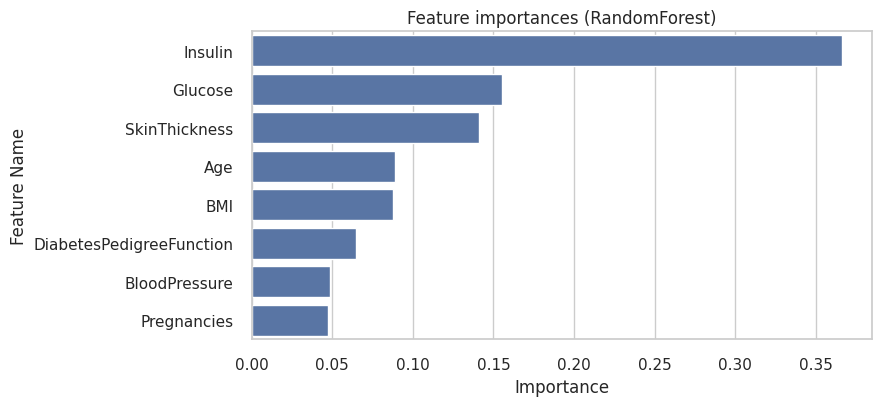

In [20]:
# Use a quick random forest to inspect which features the model finds useful
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# For RandomForest, replace zeros with median to avoid zero-as-missing problem quickly
X_rf = X.copy()
for c in zero_as_missing_cols:
    X_rf[c] = X_rf[c].replace(0, X_rf[c].median())

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_rf, y)
importances = pd.Series(rf.feature_importances_, index=X_rf.columns).sort_values(ascending=False)
print("\nRandom Forest feature importances  (feat. importance greatest to lowest):")
display(importances)


# Visualize
plt.figure(figsize=(8,4))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Feature importances (RandomForest)")
plt.xlabel("Importance")
plt.ylabel("Feature Name")

plt.show()


## Condition-wise (Diabetic vs Non-Diabetic) Distribution of features

In [21]:
px.box(df,color='Outcome')

## Insulin seems to have many outliers, median values vary most among diabetes vs non-diabetes for glucose, insulin features

## Overall Distribution of features

In [22]:
df_melted = df.melt(var_name="Feature", value_name="Value")

fig = px.box(df_melted, x="Feature", y="Value", color="Feature",
             title="Distribution of Features")
fig.show()


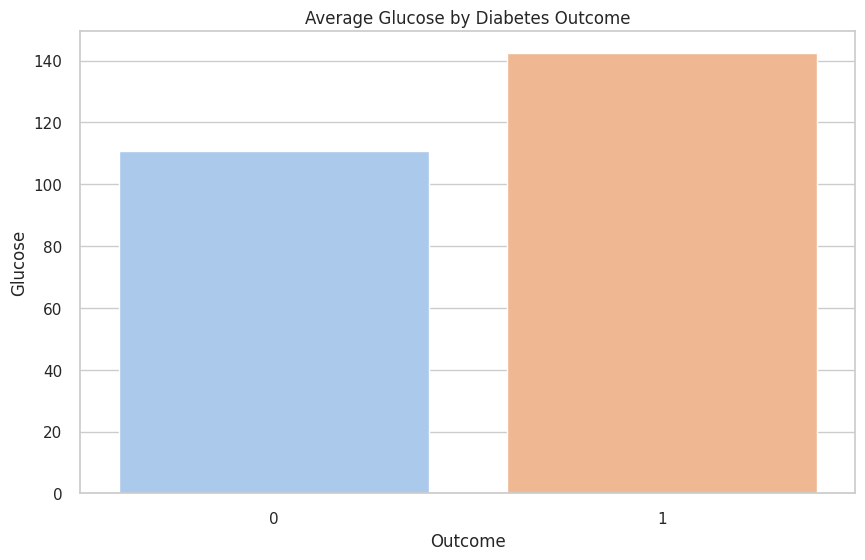

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x="Outcome", y="Glucose", data=df, palette="pastel", ci=None)
plt.title("Average Glucose by Diabetes Outcome")
plt.show()


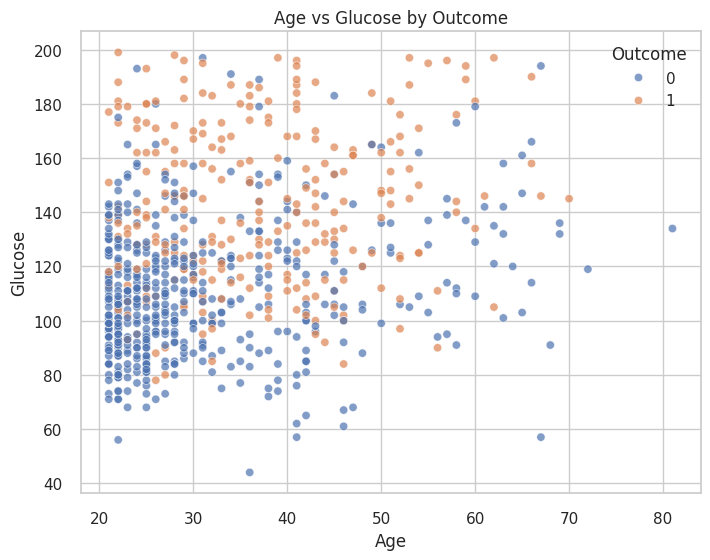

In [24]:
# Glucose vs Age colored by Outcome
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Age', y='Glucose', hue='Outcome', alpha=0.7)
plt.title("Age vs Glucose by Outcome")
plt.show()

## Most of the healthy people are present within age < 30 and glucose < 110

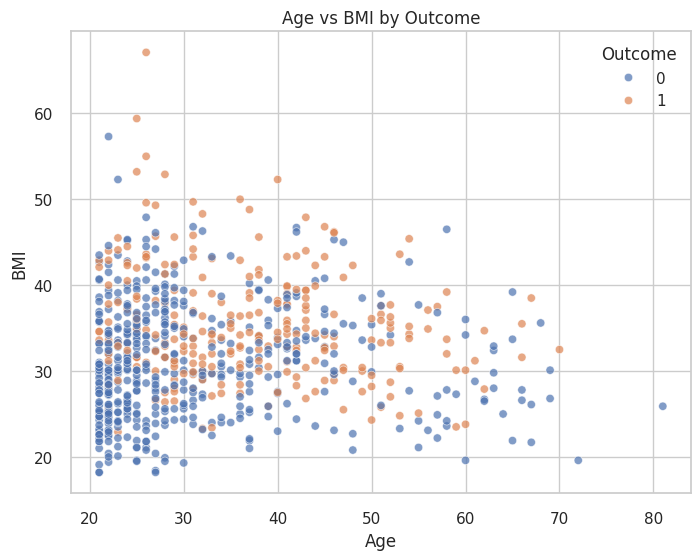

In [25]:
# BMI vs Age colored by Outcome
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Age', y='BMI', hue='Outcome', alpha=0.7)
plt.title("Age vs BMI by Outcome")
plt.show()

## Most of the healthy people are present within age < 30 and BMI < 40

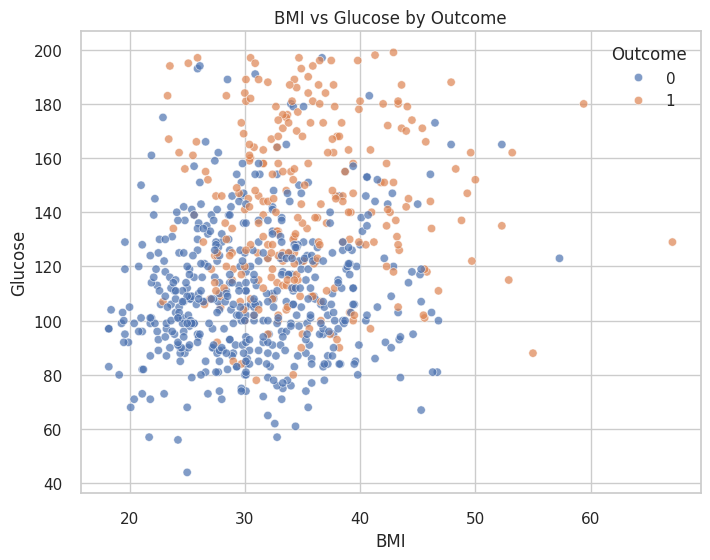

In [26]:
# Glucose vs BMI colored by Outcome
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='BMI', y='Glucose', hue='Outcome', alpha=0.7)
plt.title("BMI vs Glucose by Outcome")
plt.show()

## Most of the healthy people are present within BMI < 40 and Glucose < 120

In [27]:
px.scatter(df,df.index,'Glucose',color='Outcome',title='Glucose vs Outcome')

## Majority of diabetes(yellow ones) patient have higher glucose level compared to the non-diabetic(blue dots) ones, usually above 120 for Diabetic

In [28]:
px.scatter(df,df.index,'Insulin',color='Outcome',title='Insulin vs Outcome')


In [29]:
px.scatter(df,df.index,'Age',color='Outcome',title='Age vs Outcome')


In [30]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

## Feature Extraction

### Based upon above analysis, let's create some features by extracting information from raw features 

In [31]:
X, y = df.drop(['Outcome'],axis=1), df['Outcome']


In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

# Train a simple interpretable tree
tree = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=50,
    random_state=42
)
tree.fit(X, y)

# Print discovered rules
rules = export_text(tree, feature_names=list(X.columns))
print(rules)


|--- Insulin <= 121.00
|   |--- SkinThickness <= 28.50
|   |   |--- SkinThickness <= 26.50
|   |   |   |--- Glucose <= 106.50
|   |   |   |   |--- class: 0
|   |   |   |--- Glucose >  106.50
|   |   |   |   |--- class: 0
|   |   |--- SkinThickness >  26.50
|   |   |   |--- class: 0
|   |--- SkinThickness >  28.50
|   |   |--- DiabetesPedigreeFunction <= 0.41
|   |   |   |--- class: 0
|   |   |--- DiabetesPedigreeFunction >  0.41
|   |   |   |--- class: 0
|--- Insulin >  121.00
|   |--- Age <= 28.50
|   |   |--- Glucose <= 127.50
|   |   |   |--- class: 0
|   |   |--- Glucose >  127.50
|   |   |   |--- class: 1
|   |--- Age >  28.50
|   |   |--- Insulin <= 175.50
|   |   |   |--- Age <= 39.50
|   |   |   |   |--- class: 1
|   |   |   |--- Age >  39.50
|   |   |   |   |--- class: 1
|   |   |--- Insulin >  175.50
|   |   |   |--- class: 1



#### Tells that, Insulin <=121 is usually for Class = 0 (non-diabetic)

In [33]:
df['Feature_001'] = df.apply(lambda row: 1 if (row['Insulin'] >= 121) else 0, axis=1)
df['Feature_002'] = df.apply(lambda row: 1 if (row['Insulin'] >= 121 and row['Age'] > 28.5 ) else 0, axis=1)
df['Feature_003'] = df.apply(lambda row: 1 if (row['Insulin'] >= 121 and row['Age'] > 28.5 and row['Glucose'] > 127.5) else 0, axis=1)
df


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Feature_001,Feature_002,Feature_003
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,1,1,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,0,0,0
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,1,1,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,0,0,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0,1,1,0
764,2,122.0,70.0,27.0,102.5,36.8,0.340,27,0,0,0,0
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0,0,0,0
766,1,126.0,60.0,32.0,169.5,30.1,0.349,47,1,1,1,0


In [34]:
df.groupby('Outcome').median()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Feature_001,Feature_002,Feature_003
Outcome,,,,,,,,,,,
0,2.0,107.0,70.0,27.0,102.5,30.1,0.336,27.0,0.0,0.0,0.0
1,4.0,140.0,74.5,32.0,169.5,34.3,0.449,36.0,1.0,1.0,0.0


In [35]:
df.groupby('Outcome').describe()


Pregnancies                                                Glucose  \
              count      mean       std  min   25%  50%  75%   max   count   
Outcome                                                                      
0             500.0  3.298000  3.017185  0.0  1.00  2.0  5.0  13.0   500.0   
1             268.0  4.865672  3.741239  0.0  1.75  4.0  8.0  17.0   268.0   

                                                                  \
               mean        std   min    25%    50%    75%    max   
Outcome                                                            
0        110.622000  24.703920  44.0   93.0  107.0  125.0  197.0   
1        142.302239  29.488811  78.0  119.0  140.0  167.0  199.0   

        BloodPressure                                                       \
                count       mean        std   min   25%   50%   75%    max   
Outcome                                                                      
0               500.0  70.844000  11.928631  24.0  63.5  70.0  78.0  122.0   
1               268.0  75.272388  11.927232  30.0  68.0  74.5  82.0  114.0   

        SkinThickness                                                    \
                count       mean       std  min   25%   50%   75%   max   
Outcome                                                                   
0               500.0  27.170000  8.516935  7.0  22.0  27.0  31.0  60.0   
1               268.0  32.671642  8.469178  7.0  30.0  32.0  36.0  99.0   

        Insulin                                                           \
          count        mean        std   min    25%    50%    75%    max   
Outcome                                                                    
0         500.0  117.172000  75.685302  15.0   95.0  102.5  105.0  744.0   
1         268.0  187.615672  94.114420  14.0  169.5  169.5  169.5  846.0   

           BMI                                                        \
         count       mean       std   min    25%   50%     75%   max   
Outcome                                                                
0        500.0  30.846000  6.502089  18.2  25.75  30.1  35.300  57.3   
1        268.0  35.398507  6.590852  22.9  30.90  34.3  38.775  67.1   

        DiabetesPedigreeFunction                                             \
                           count      mean       std    min      25%    50%   
Outcome                                                                       
0                          500.0  0.429734  0.299085  0.078  0.22975  0.336   
1                          268.0  0.550500  0.372354  0.088  0.26250  0.449   

                           Age                                                \
             75%    max  count       mean        std   min   25%   50%   75%   
Outcome                                                                        
0        0.56175  2.329  500.0  31.190000  11.667655  21.0  23.0  27.0  37.0   
1        0.72800  2.420  268.0  37.067164  10.968254  21.0  28.0  36.0  44.0   

              Feature_001                                               \
          max       count      mean       std  min  25%  50%  75%  max   
Outcome                                                                  
0        81.0       500.0  0.200000  0.400401  0.0  0.0  0.0  0.0  1.0   
1        70.0       268.0  0.895522  0.306451  0.0  1.0  1.0  1.0  1.0   

        Feature_002                                              Feature_003  \
              count      mean       std  min  25%  50%  75%  max       count   
Outcome                                                                        
0             500.0  0.068000  0.251998  0.0  0.0  0.0  0.0  1.0       500.0   
1             268.0  0.690299  0.463236  0.0  0.0  1.0  1.0  1.0       268.0   

                                                      
             mean       std  min  25%  50%  75%  max  
Outcome                                               
0        0.040000  0.196155  0.0 

In [36]:
df['Feature_1'] = df.apply(lambda row: 0 if (row['Age'] <= 37 and row['Glucose'] <=120) else 1, axis=1)
df['Feature_2'] = df.apply(lambda row: 1 if (row['BMI'] >= 35) else 0, axis=1)
df['Feature_3'] = df.apply(lambda row: 0 if (row['Age'] <= 30 and row['Pregnancies'] <=6) else 1, axis=1)
df['Feature_4'] = df.apply(lambda row: 0 if (row['Glucose'] <= 105 and row['BloodPressure'] <= 80) else 1, axis=1)
df['Feature_5'] = df.apply(lambda row: 0 if (row['SkinThickness'] <= 31) else 1, axis=1)
df['Feature_6'] = df.apply(lambda row: 0 if (row['BMI'] <= 35 and row['SkinThickness'] <=31) else 1, axis=1)
df['Feature_7'] = df.apply(lambda row: 1 if (row['Glucose'] <= 125 and row['BMI'] <= 30) else 0, axis=1)
df['Feature_8'] = df.apply(lambda row: 1 if (row['BloodPressure'] >= 80) else 0, axis=1)
df['Feature_9'] = df['Pregnancies'].apply(lambda x: 0 if 0 <= x <= 5 else 1)



df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Feature_001,Feature_002,Feature_003,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,1,1,1,1,0,1,1,1,1,0,0,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,0,0,0,0,0,1,0,0,0,1,0,0
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,1,1,1,1,0,1,1,1,1,0,0,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,1,1,1,1,1,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0,1,1,0,1,0,1,0,1,1,0,0,1
764,2,122.0,70.0,27.0,102.5,36.8,0.340,27,0,0,0,0,1,1,0,1,0,1,0,0,0
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0,0,0,0,1,0,0,1,0,0,1,0,0
766,1,126.0,60.0,32.0,169.5,30.1,0.349,47,1,1,1,0,1,0,1,1,1,1,0,0,0


In [37]:
df['N1'] = df['BMI'] * df['SkinThickness']

df['N2'] =  df['Pregnancies'] / df['Age']

df['N3'] = df['Glucose'] / df['DiabetesPedigreeFunction']

df['N4'] = df['Age'] * df['DiabetesPedigreeFunction']

df['N5'] = df['Age'] / df['Insulin']


In [38]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'Feature_001',
       'Feature_002', 'Feature_003', 'Feature_1', 'Feature_2', 'Feature_3',
       'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8',
       'Feature_9', 'N1', 'N2', 'N3', 'N4', 'N5'],
      dtype='object')

In [39]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Feature_001,Feature_002,Feature_003,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,N1,N2,N3,N4,N5
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,1,1,1,1,0,1,1,1,1,0,0,1,1176.0,0.120000,236.044657,31.350,0.294985
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,0,0,0,0,0,1,0,0,0,1,0,0,771.4,0.032258,242.165242,10.881,0.302439
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,1,1,1,1,0,1,1,1,1,0,0,1,745.6,0.250000,272.321429,21.504,0.188791
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,0,0,0,0,0,0,0,0,0,1,0,0,646.3,0.047619,532.934132,3.507,0.223404
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,1,1,1,1,1,1,1,1,1,0,0,0,1508.5,0.000000,59.877622,75.504,0.196429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0,1,1,0,1,0,1,0,1,1,0,0,1,1579.2,0.158730,590.643275,10.773,0.350000
764,2,122.0,70.0,27.0,102.5,36.8,0.340,27,0,0,0,0,1,1,0,1,0,1,0,0,0,993.6,0.074074,358.823529,9.180,0.263415
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0,0,0,0,1,0,0,1,0,0,1,0,0,602.6,0.166667,493.877551,7.350,0.267857
766,1,126.0,60.0,32.0,169.5,30.1,0.349,47,1,1,1,0,1,0,1,1,1,1,0,0,0,963.2,0.021277,361.031519,16.403,0.277286


In [40]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Feature_001,Feature_002,Feature_003,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,N1,N2,N3,N4,N5
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,1,1,1,1,0,1,1,1,1,0,0,1,1176.0,0.120000,236.044657,31.350,0.294985
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,0,0,0,0,0,1,0,0,0,1,0,0,771.4,0.032258,242.165242,10.881,0.302439
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,1,1,1,1,0,1,1,1,1,0,0,1,745.6,0.250000,272.321429,21.504,0.188791
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,0,0,0,0,0,0,0,0,0,1,0,0,646.3,0.047619,532.934132,3.507,0.223404
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,1,1,1,1,1,1,1,1,1,0,0,0,1508.5,0.000000,59.877622,75.504,0.196429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0,1,1,0,1,0,1,0,1,1,0,0,1,1579.2,0.158730,590.643275,10.773,0.350000
764,2,122.0,70.0,27.0,102.5,36.8,0.340,27,0,0,0,0,1,1,0,1,0,1,0,0,0,993.6,0.074074,358.823529,9.180,0.263415
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0,0,0,0,1,0,0,1,0,0,1,0,0,602.6,0.166667,493.877551,7.350,0.267857
766,1,126.0,60.0,32.0,169.5,30.1,0.349,47,1,1,1,0,1,0,1,1,1,1,0,0,0,963.2,0.021277,361.031519,16.403,0.277286


In [41]:


# # Replace inf, -inf with NaN
# df = df.replace([np.inf, -np.inf], np.nan)

# # Drop rows with NaN OR fill missing
# # Option 1: Fill NaN
# df = df.fillna(0)

# # OR Option 2: Drop NaN rows
# # X = X.dropna()


## Scaling and encoding

In [42]:
target_col = ["Outcome"]
cat_cols   = df.nunique()[df.nunique() < 12].keys().tolist()
cat_cols   = [x for x in cat_cols ]
#numerical columns
num_cols   = [x for x in df.columns if x not in cat_cols + target_col]
#Binary columns with 2 values
bin_cols   = df.nunique()[df.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    df[i] = le.fit_transform(df[i])
    
#Duplicating columns for multi value columns
df = pd.get_dummies(data = df,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
# df_df_og = df.copy()
df = df.drop(columns = num_cols,axis = 1)
df = df.merge(scaled,left_index=True,right_index=True,how = "left")

In [43]:
df

,Outcome,Feature_001,Feature_002,Feature_003,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,N1,N2,N3,N4,N5
0,1,1,1,1,1,0,1,1,1,1,0,0,1,0.639947,0.864625,-0.032180,0.665181,0.311604,0.169483,0.468492,1.425995,0.436284,0.144246,-0.561641,1.202461,-0.023905
1,0,0,0,0,0,0,1,0,0,0,1,0,0,-0.844885,-1.204727,-0.528124,-0.010112,-0.440843,-0.848549,-0.365061,-0.190672,-0.455696,-0.929227,-0.538026,-0.382029,0.014204
2,1,1,1,1,1,0,1,1,1,1,0,0,1,1.233880,2.014265,-0.693438,0.327535,0.311604,-1.328478,0.604397,-0.105584,-0.512575,1.734723,-0.421674,0.440289,-0.566853
3,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.844885,-1.073339,-0.528124,-0.685405,-0.536303,-0.630399,-0.920763,-1.041549,-0.731491,-0.741294,0.583847,-0.952845,-0.389882
4,1,1,1,1,1,1,1,1,1,1,0,0,0,-1.141852,0.503310,-2.677212,0.665181,0.294758,1.551096,5.484909,-0.020496,1.169312,-1.323886,-1.241345,4.620388,-0.527802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0,1,1,0,1,0,1,0,1,1,0,0,1,1.827813,-0.679177,0.298449,2.128317,0.429525,0.067679,-0.908682,2.532136,1.325177,0.618088,0.806506,-0.390389,0.257372
764,0,0,0,0,1,1,0,1,0,1,0,0,0,-0.547919,0.010607,-0.197495,-0.235210,-0.440843,0.634868,-0.398282,-0.531023,0.034165,-0.417632,-0.087923,-0.513702,-0.185318
765,0,0,0,0,1,0,0,1,0,0,1,0,0,0.342981,-0.022240,-0.032180,-0.685405,-0.334153,-0.906722,-0.685193,-0.275760,-0.827832,0.715187,0.433155,-0.655361,-0.162605
766,1,1,1,0,1,0,1,1,1,1,0,0,0,-0.844885,0.141994,-1.024067,0.327535,0.311604,-0.339533,-0.371101,1.170732,-0.032855,-1.063579,-0.079404,0.045425,-0.114396


# Apply ML

## Splitting data

In [44]:
X, y = df.drop(['Outcome'],axis=1), df['Outcome']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)    # 20% for testing, 80% for training

In [46]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 25), (154, 25), (614,), (154,))

In [47]:
def show_eval_metrics(y_true, y_pred):

    # Confusion matrix for FPR/TPR
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2,2):  # Binary classification
        TN, FP, FN, TP = cm.ravel()
        fpr = FP / (FP + TN)
        tpr = TP / (TP + FN)
    else:
        # Multiclass average
        fpr = np.mean([FP / (FP + TN) for TN, FP, FN, TP in [
            (cm.sum(axis=1)[i]-cm[i,i], cm[:,i].sum()-cm[i,i], cm[i,:].sum()-cm[i,i], cm[i,i])
            for i in range(cm.shape[0])
        ]])
        tpr = np.mean([cm[i,i]/cm[i,:].sum() for i in range(cm.shape[0])])

    # Compute all metrics
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy','Precision_Macro','Recall_Macro','F1_Macro',
                'Precision_Micro','Recall_Micro','F1_Micro','MCC','FPR','TPR'],
        'Value': [accuracy_score(y_true, y_pred),
                precision_score(y_true, y_pred, average='macro'),
                recall_score(y_true, y_pred, average='macro'),
                f1_score(y_true, y_pred, average='macro'),
                precision_score(y_true, y_pred, average='micro'),
                recall_score(y_true, y_pred, average='micro'),
                f1_score(y_true, y_pred, average='micro'),
                matthews_corrcoef(y_true, y_pred),
                fpr,
                tpr]
    })

    return metrics_df



##  Model Performance evaluation

To measure the performance of a model, we need several elements :

This part is essential

* **Confusion matrix** : also known as the error matrix, allows visualization of the performance of an algorithm :

    * true positive (TP) : Diabetic correctly identified as diabetic
    * true negative (TN) : Healthy correctly identified as healthy
    * false positive (FP) : Healthy incorrectly identified as diabetic
    * false negative (FN) : Diabetic incorrectly identified as healthy

![](https://image.noelshack.com/fichiers/2018/20/5/1526651914-cs-heezweaa5hp7.jpg)

* **Metrics ** :

    * Accuracy : (TP +TN) / (TP + TN + FP +FN)
    * Precision : TP / (TP + FP)
    * Recall : TP / (TP + FN)
    * F1 score : 2 x ((Precision x Recall) / (Precision + Recall))

* **Roc Curve** : The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

![](http://image.noelshack.com/fichiers/2019/06/1/1549284841-0-0-0-0-0-0-0-0-0-0.png)

* **Precision Recall Curve** :  shows the tradeoff between precision and recall for different threshold

To train and test our algorithm we'll use cross validation K-Fold

![](http://image.noelshack.com/fichiers/2019/06/1/1549288372-00001.png)

In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k − 1 subsamples are used as training data. The cross-validation process is then repeated k times, with each of the k subsamples used exactly once as the validation data. The k results can then be averaged to produce a single estimation. The advantage of this method over repeated random sub-sampling is that all observations are used for both training and validation, and each observation is used for validation exactly once.

Bellow we define a stylized report with Plotly

In [48]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    precision_recall_curve, roc_curve, auc,
    confusion_matrix, make_scorer
)
from sklearn.model_selection import (
    KFold, cross_val_score, cross_val_predict
)
from scipy import interp
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.offline as py

# ---------------- CUSTOM SCORER ---------------- #
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

specificity = make_scorer(specificity_score)

# ---------------- MODEL PERFORMANCE ---------------- #
def model_performance(model, subtitle):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    y_real = []
    y_proba = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for train, test in cv.split(X, y):
        model.fit(X.iloc[train], y.iloc[train])
        pred_proba = model.predict_proba(X.iloc[test])

        precision, recall, _ = precision_recall_curve(y.iloc[test], pred_proba[:, 1])
        y_real.append(y.iloc[test])
        y_proba.append(pred_proba[:, 1])

        fpr, tpr, _ = roc_curve(y.iloc[test], pred_proba[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        aucs.append(auc(fpr, tpr))
    
    # Confusion matrix
    y_pred = cross_val_predict(model, X, y, cv=5)
    conf_matrix = confusion_matrix(y, y_pred)
    
    # Compute metrics
    tp = conf_matrix[1, 1]
    fn = conf_matrix[1, 0]
    fp = conf_matrix[0, 1]
    tn = conf_matrix[0, 0]

    Accuracy  = (tp + tn) / (tp + tn + fp + fn)
    Precision = tp / (tp + fp)
    Recall    = tp / (tp + fn)
    Specificity = tn / (tn + fp)
    F1_score  = 2 * ((Precision * Recall) / (Precision + Recall))

    show_metrics = pd.DataFrame(
        data=[[Accuracy, Precision, Recall, Specificity, F1_score]],
        columns=['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1_score']
    ).T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue', 'violet']
    
    # ---- PLOTS ---- #
    trace1 = go.Heatmap(
        z=conf_matrix,
        x=["0 (pred)", "1 (pred)"],
        y=["0 (true)", "1 (true)"],
        xgap=2, ygap=2,
        colorscale='Viridis',
        showscale=False
    )

    trace2 = go.Bar(
        x=show_metrics[0].values,
        y=['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1_score'],
        text=np.round_(show_metrics[0].values, 4),
        textposition='auto',
        textfont=dict(color='black'),
        orientation='h',
        opacity=1,
        marker=dict(color=colors, line=dict(color='#000000', width=1.5))
    )

    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = round(auc(mean_fpr, mean_tpr), 3)
    trace3 = go.Scatter(x=mean_fpr, y=mean_tpr,
                        name=f"ROC (AUC = {mean_auc})",
                        line=dict(color='royalblue', width=2),
                        fill='tozeroy')
    trace4 = go.Scatter(x=[0, 1], y=[0, 1],
                        line=dict(color='black', width=1.5, dash='dot'))

    y_real = y
    y_proba = np.concatenate(y_proba)
    precision, recall, _ = precision_recall_curve(y_real, y_proba)
    trace5 = go.Scatter(
        x=recall, y=precision,
        name="Precision-Recall",
        line=dict(color='lightcoral', width=2),
        fill='tozeroy'
    )

    # ---- Subplots ---- #
    fig = tls.make_subplots(
        rows=2, cols=2, print_grid=False,
        specs=[[{}, {}], [{}, {}]],
        subplot_titles=('Confusion Matrix', 'Metrics',
                        f'ROC Curve (AUC = {mean_auc})',
                        'Precision-Recall Curve')
    )

    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 2)
    fig.append_trace(trace3, 2, 1)
    fig.append_trace(trace4, 2, 1)
    fig.append_trace(trace5, 2, 2)

    fig['layout'].update(
        showlegend=False,
        title=f'<b>Model Performance Report (5 folds)</b><br>{subtitle}',
        autosize=False, height=830, width=830,
        plot_bgcolor='black', paper_bgcolor='black',
        margin=dict(b=195),
        font=dict(color='white')
    )
    for i in fig['layout']['annotations']:
        i['font'] = dict(color='white', size=14)

    py.iplot(fig)

# ---------------- SCORES TABLE ---------------- #
def scores_table(model, subtitle):
    scorers = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'specificity': specificity,
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }

    res = []
    for sc_name, sc_func in scorers.items():
        scores = cross_val_score(model, X, y, cv=5, scoring=sc_func)
        res.append(scores)

    df = pd.DataFrame(res, index=scorers.keys()).T
    df.loc['mean'] = df.mean()
    df.loc['std'] = df.std()

    trace = go.Table(
        header=dict(
            values=['<b>Fold', '<b>Accuracy', '<b>Precision', '<b>Recall', '<b>Specificity', '<b>F1 Score', '<b>ROC AUC'],
            line=dict(color='#7D7F80'),
            fill=dict(color='#a1c3d1'),
            align=['center'],
            font=dict(size=15)
        ),
        cells=dict(
            values=[
                ('1', '2', '3', '4', '5', 'mean', 'std'),
                np.round(df['accuracy'], 3),
                np.round(df['precision'], 3),
                np.round(df['recall'], 3),
                np.round(df['specificity'], 3),
                np.round(df['f1'], 3),
                np.round(df['roc_auc'], 3)
            ],
            line=dict(color='#7D7F80'),
            fill=dict(color='#EDFAFF'),
            align=['center'],
            font=dict(size=15)
        )
    )

    layout = dict(
        width=800, height=400,
        title=f'<b>Cross Validation - 5 folds</b><br>{subtitle}',
        font=dict(size=15)
    )

    fig = dict(data=[trace], layout=layout)
    py.iplot(fig, filename='styled_table')


## Machine Learning 

In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, cohen_kappa_score, roc_auc_score, confusion_matrix
)
from xgboost import XGBClassifier

# ==============================
# Example Dataset (replace with yours)
# ==============================
# from sklearn.datasets import make_classification
# X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# ==============================
# Preprocessing
# ==============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==============================
# XGBoost Model + Param Grid
# ==============================
xgb_model = XGBClassifier(
    tree_method="hist",      # ✅ CPU version (stable)
    objective="binary:logistic",
    eval_metric="logloss",   # ✅ correct usage
    use_label_encoder=False,
    random_state=42,
    verbosity=0
)

param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

# ==============================
# Cross-validation
# ==============================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="f1",
    cv=cv,
    verbose=2,
    n_jobs=-1
)

# ==============================
# Fit (safe CPU)
# ==============================
grid_search.fit(X_scaled, y)

print("\n✅ Best Parameters:", grid_search.best_params_)
print("✅ Best F1 Score:", grid_search.best_score_)

# ==============================
# Evaluate on Full Data
# ==============================
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_scaled)

print("\n--- Final Evaluation ---")
print("Accuracy:", accuracy_score(y, y_pred))
print("Precision:", precision_score(y, y_pred))
print("Recall:", recall_score(y, y_pred))
print("F1 Score:", f1_score(y, y_pred))
print("MCC:", matthews_corrcoef(y, y_pred))
print("Kappa:", cohen_kappa_score(y, y_pred))
print("ROC AUC:", roc_auc_score(y, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END c

In [50]:
model_performance(best_model, 'XGB')
scores_table(best_model, 'XGB')

## Lightbgm

In [51]:
random_state=42

# fit_params = {"early_stopping_rounds" : 100, 
#              "eval_metric" : 'auc', 
#              "eval_set" : [(X,y)],
#              'eval_names': ['valid'],
#              'verbose': 0,
#              'categorical_feature': 'auto'}
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
callbacks = [
    early_stopping(stopping_rounds=100, verbose=False),
    log_evaluation(period=0)  # disables logging
]

fit_params = {
    "eval_set": [(X, y)],
    "eval_metric": "auc",
    "callbacks": callbacks,
    "categorical_feature": "auto"
}


param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#number of combinations
n_iter = 300

#intialize lgbm and lunch the search
# lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, silent=True, metric='None', n_jobs=4)
lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, silent=True, metric='None', n_jobs=4, verbose=-1)

grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=random_state,
    verbose=True)

grid_search.fit(X, y, **fit_params)
opt_parameters =  grid_search.best_params_
lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


In [52]:
model_performance(lgbm_clf, 'LightGBM')
scores_table(lgbm_clf, 'LightGBM')

## LGBM + KNN

We obtain a really good result but we can beat 90% with adding a KNeighborsClassifier to LightGBM (Voting Classifier)

* **KNeighborsClassifier** : KNeighborsClassifier implements learning based on the k nearest neighbors of each query point, where  k is an integer value specified by the user.

* **VotingClassifier** : VotingClassifier is a meta-classifier for combining similar or conceptually different machine learning classifiers for classification via majority or plurality voting

With GridSearch CV we search the best "n_neighbors" to optimize accuracy of Voting Classifier

In [53]:
knn_clf = KNeighborsClassifier()

voting_clf = VotingClassifier(estimators=[ 
    ('lgbm_clf', lgbm_clf),
    ('knn', KNeighborsClassifier())], voting='soft', weights = [1,1])

params = {
      'knn__n_neighbors': np.arange(1,30)
      }
      
grid = GridSearchCV(estimator=voting_clf, param_grid=params, cv=5)

grid.fit(X,y)

print("Best Score:" + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

Best Score:0.8828622358034123
Best Parameters: {'knn__n_neighbors': 10}


In [54]:
knn_clf = KNeighborsClassifier(n_neighbors = grid.best_params_['knn__n_neighbors'])

voting_clf = VotingClassifier (
        estimators = [('knn', knn_clf), ('lgbm_clf', lgbm_clf)],
                     voting='soft', weights = [1,1])

In [55]:
model_performance(voting_clf, 'lgbm & KNN')
scores_table(voting_clf, 'lgbm & KNN')

## XGB + KNN

In [56]:
knn_clf = KNeighborsClassifier()

voting_clf = VotingClassifier(estimators=[ 
    ('xgb_clf', best_model),
    ('knn', KNeighborsClassifier())], voting='soft', weights = [1,1])

params = {
      'knn__n_neighbors': np.arange(1,30)
      }
      
grid = GridSearchCV(estimator=voting_clf, param_grid=params, cv=5)

grid.fit(X,y)

print("Best Score:" + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

Best Score:0.8893727187844835
Best Parameters: {'knn__n_neighbors': 15}


In [57]:
knn_clf = KNeighborsClassifier(n_neighbors = 6)

voting_clf = VotingClassifier (
        estimators = [('knn', knn_clf), ('xgb_clf', best_model)],
                     voting='soft', weights = [1,1])

In [58]:
model_performance(voting_clf, 'XGB & KNN')
scores_table(voting_clf, 'XGB & KNN')

## XGB seems to give best performance, with ROC of 95 and other parameters as following

In [59]:
model_performance(best_model, 'XGB')
scores_table(best_model, 'XGB')

## The features extracted based upon the outcome, feature relationships, gives idea about the values of clinical parameters that can be used to distinguish b/w diabetic and non-diabetic cases

#### Feature_1  = 0 if ('Age' <= 37 and 'Glucose' <=120) else 1 
#### Feature_2 = 1 if ('BMI' >= 35) else 0
#### Feature_3 = 0 if ('Age' <= 30 and 'Pregnancies' <=6) else 1
#### Feature_4 = 0 if ('Glucose' <= 105 and 'BloodPressure' <= 80) else 1
#### Feature_5 = 0 if ('SkinThickness' <= 31) else 1
#### Feature_6 = 0 if ('BMI' <= 35 and 'SkinThickness' <=31) else 1
#### Feature_7 = 1 if ('Glucose' <= 125 and 'BMI' <= 30) else 0
#### Feature_8 = 1 if ('BloodPressure' >= 80) else 0
#### Feature_9 =  0 if 0 <= 'Pregnancies' <= 5 else 1


#### Here  0 = non-diabetic, 1 = diabetic